# 21-time-series-eda
> Time series analysis

The purpose of this notebook series is to perform a time series analysis as a part of the EDA step of the project. This will be helpful in discovering any seasonality, as well as determining if the data is stationary, autocorrelated, and possibly perform some decomposition to prepare for the forecasting. 

### Import pandas and read in data

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('/data/p_dsi/teams2023/team9/')

df = pd.read_csv('Asurion_clean_data.csv')

df["make"] = np.where(df["phone model"].str.startswith("alcatel"), "alcatel",
             np.where(df["phone model"].str.startswith("apple"), "apple",
             np.where(df["phone model"].str.startswith("samsung"), "samsung", 
             np.where(df["phone model"].str.startswith("lg"), "lg",
             np.where(df["phone model"].str.startswith("google"), "google", "other")))))


others = df[df["make"] == "other"]

others.groupby("phone model")["phone model"].count()

df.head()

,phone model,phone size,phone color,claim,weeks_monday,make
0,alcatel axel,32gb,black,1,2022-01-24,alcatel
1,alcatel axel,32gb,black,3,2022-11-14,alcatel
2,alcatel axel,32gb,black,1,2022-11-21,alcatel
3,alcatel axel,32gb,black,3,2022-11-28,alcatel
4,alcatel axel,32gb,black,1,2022-12-12,alcatel


### Setting measure of time as index for each data set
> Should improve ease of use for some future packages

In [2]:
df['weeks_monday'] = pd.to_datetime(df['weeks_monday'], format='%Y-%m-%d')

print(df.head())

    phone model phone size phone color  claim weeks_monday     make
0  alcatel axel       32gb       black      1   2022-01-24  alcatel
1  alcatel axel       32gb       black      3   2022-11-14  alcatel
2  alcatel axel       32gb       black      1   2022-11-21  alcatel
3  alcatel axel       32gb       black      3   2022-11-28  alcatel
4  alcatel axel       32gb       black      1   2022-12-12  alcatel


### Creating iPhone 14 subset for initial plot analysis
> Must first select only those that are listed as iphone 14  
> Then, group by model and weeks to find combination

In [3]:
iphone14 = df[df["phone model"].str.startswith("apple iphone 14")]
iphone14 = iphone14.groupby(["weeks_monday", "phone model"]).agg({"claim": ["sum"]})
iphone14.columns = ['claims']

print(iphone14)

                                      claims
weeks_monday phone model                    
2022-11-14   apple iphone 14               9
2022-11-21   apple iphone 14              30
2022-11-28   apple iphone 14              23
2022-12-05   apple iphone 14              43
2022-12-12   apple iphone 14              32
2022-12-19   apple iphone 14              36
2022-12-26   apple iphone 14              44
2023-01-02   apple iphone 14              45
2023-01-09   apple iphone 14              59
2023-01-16   apple iphone 14              60
2023-01-23   apple iphone 14              57
2023-01-30   apple iphone 14              54
2023-02-06   apple iphone 14              61
             apple iphone 14 pro max     190
2023-02-13   apple iphone 14              10
             apple iphone 14 pro max      54


### Initial time-series plots

<Figure size 720x720 with 0 Axes>

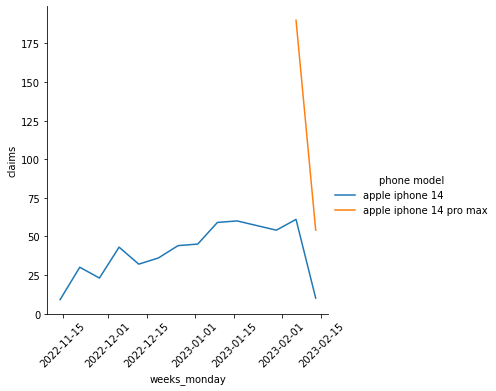

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.relplot(data=iphone14, x="weeks_monday", y="claims", kind="line", hue = "phone model")
plt.xticks(rotation=45)
plt.show()

### Grouping by make and plotting based on that

In [5]:
makes = df[df.make != "other"]

makes = makes.groupby(["weeks_monday", "make"]).agg({"claim": ["sum"]})
makes.columns = ['claims']

print(makes)

                      claims
weeks_monday make           
2021-06-28   apple      3776
             lg           18
             samsung     990
2021-07-05   apple      9649
             lg           43
...                      ...
2023-02-06   samsung    3852
2023-02-13   apple      2376
             google        5
             lg            4
             samsung     752

[332 rows x 1 columns]


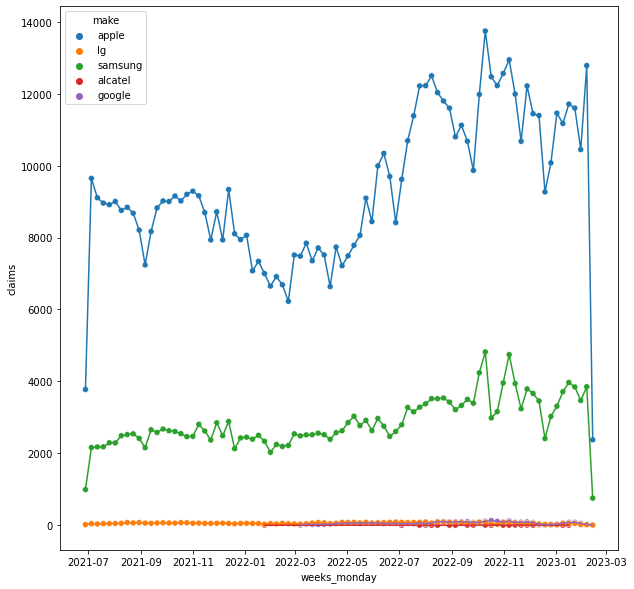

In [6]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=makes, x='weeks_monday', y='claims', hue='make', sizes=(50,500))
sns.lineplot(data=makes, x='weeks_monday', y='claims', hue='make', legend = False)
plt.show()

## Initial observations
* Only Apple and Samsung have enough claims each week to be able to follow any kind of trend  
* Therefore, I think we should subset the data to only include phones made from these brands

### Re-trim data to only include Apple and Samsung

In [7]:
apple = df[df["make"] == "apple"]
samsung = df[df["make"] == "samsung"]
temp = [apple, samsung]
df_new = pd.concat(temp)
df_new.head()

,phone model,phone size,phone color,claim,weeks_monday,make
32,apple iphone 11,128gb,black,111,2021-06-28,apple
33,apple iphone 11,128gb,black,319,2021-07-05,apple
34,apple iphone 11,128gb,black,320,2021-07-12,apple
35,apple iphone 11,128gb,black,305,2021-07-19,apple
36,apple iphone 11,128gb,black,269,2021-07-26,apple


### Plotting just Apple and Samsung

In [8]:
df_new_group = df_new.groupby(["weeks_monday", "make"]).agg({"claim": ["sum"]})
df_new_group.columns = ['claims']
df_new_group.head()

claims
weeks_monday make           
2021-06-28   apple      3776
             samsung     990
2021-07-05   apple      9649
             samsung    2161
2021-07-12   apple      9106

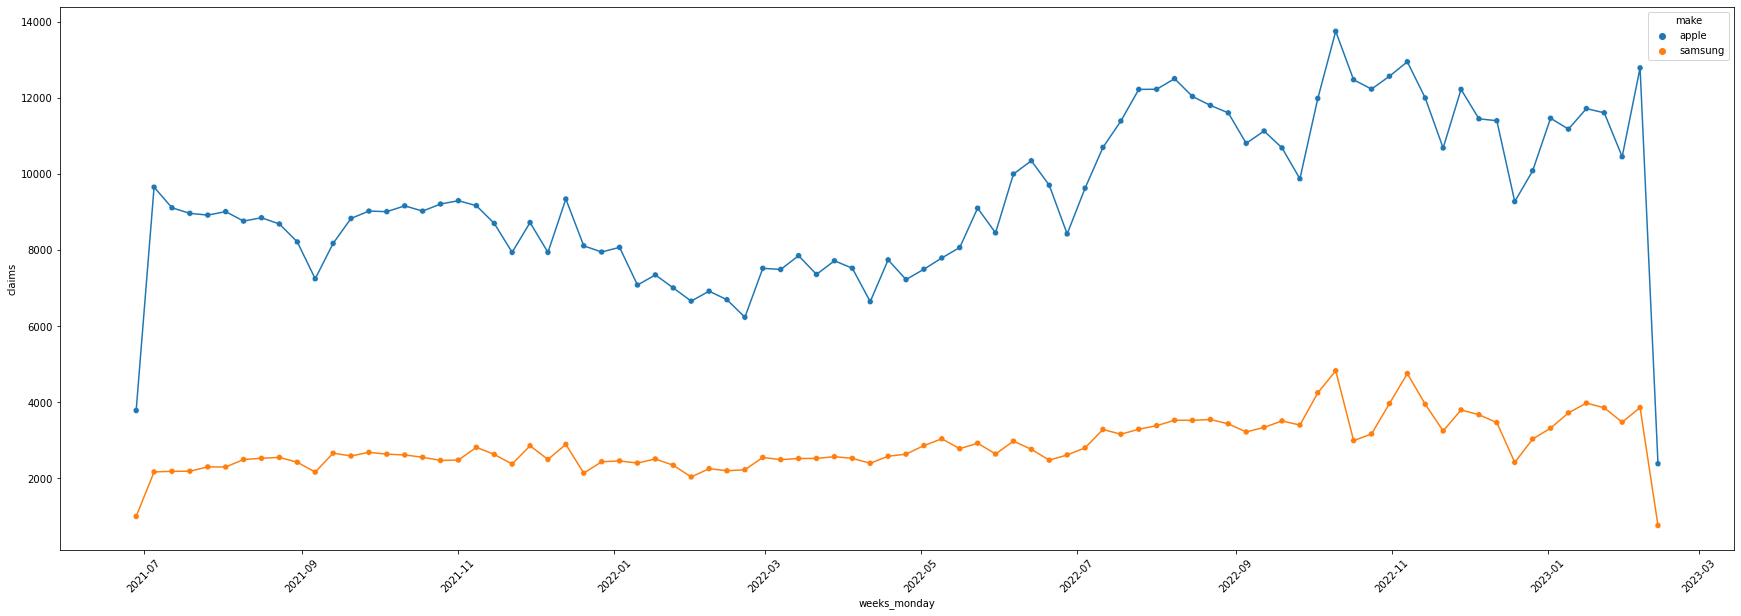

In [9]:
plt.figure(figsize=(30,10))
sns.scatterplot(data=df_new_group, x='weeks_monday', y='claims', hue='make', sizes=(50,500))
sns.lineplot(data=df_new_group, x='weeks_monday', y='claims', hue='make', legend = False)
plt.xticks(rotation=45)
plt.show()

## More comments
* With this somewhat cleaned data, we can check for stationarity in both apple and samsung products
* Can also check for autocorrelation between products

### Data Related Comments
* The phone model column is so messy, it will be hard to look into all the models for each brand
* Want to discuss what we use (maybe like find the mean/median and only include models 3 std from that)

# Stationarity
> Using a rolling mean of the data to check how it may change with seasonality for both apple and samsung

In [10]:
apple_new = apple.groupby(["weeks_monday"]).agg({"claim": ["sum"]})
apple_new.columns = ["claims"]
apple_rm = apple_new["claims"].rolling(4).mean()
samsung_new = samsung.groupby(["weeks_monday"]).agg({"claim": ["sum"]})
samsung_new.columns = ["claims"]
samsung_rm = samsung_new["claims"].rolling(4).mean()
print(apple_new.head())
print(apple_rm)
print(samsung_new.head())
print(samsung_rm)

              claims
weeks_monday        
2021-06-28      3776
2021-07-05      9649
2021-07-12      9106
2021-07-19      8960
2021-07-26      8914
weeks_monday
2021-06-28         NaN
2021-07-05         NaN
2021-07-12         NaN
2021-07-19     7872.75
2021-07-26     9157.25
                ...   
2023-01-16    11107.00
2023-01-23    11488.00
2023-01-30    11234.75
2023-02-06    11637.50
2023-02-13     9303.00
Name: claims, Length: 86, dtype: float64
              claims
weeks_monday        
2021-06-28       990
2021-07-05      2161
2021-07-12      2177
2021-07-19      2180
2021-07-26      2293
weeks_monday
2021-06-28        NaN
2021-07-05        NaN
2021-07-12        NaN
2021-07-19    1877.00
2021-07-26    2202.75
               ...   
2023-01-16    3505.25
2023-01-23    3710.25
2023-01-30    3749.75
2023-02-06    3784.50
2023-02-13    2979.75
Name: claims, Length: 86, dtype: float64


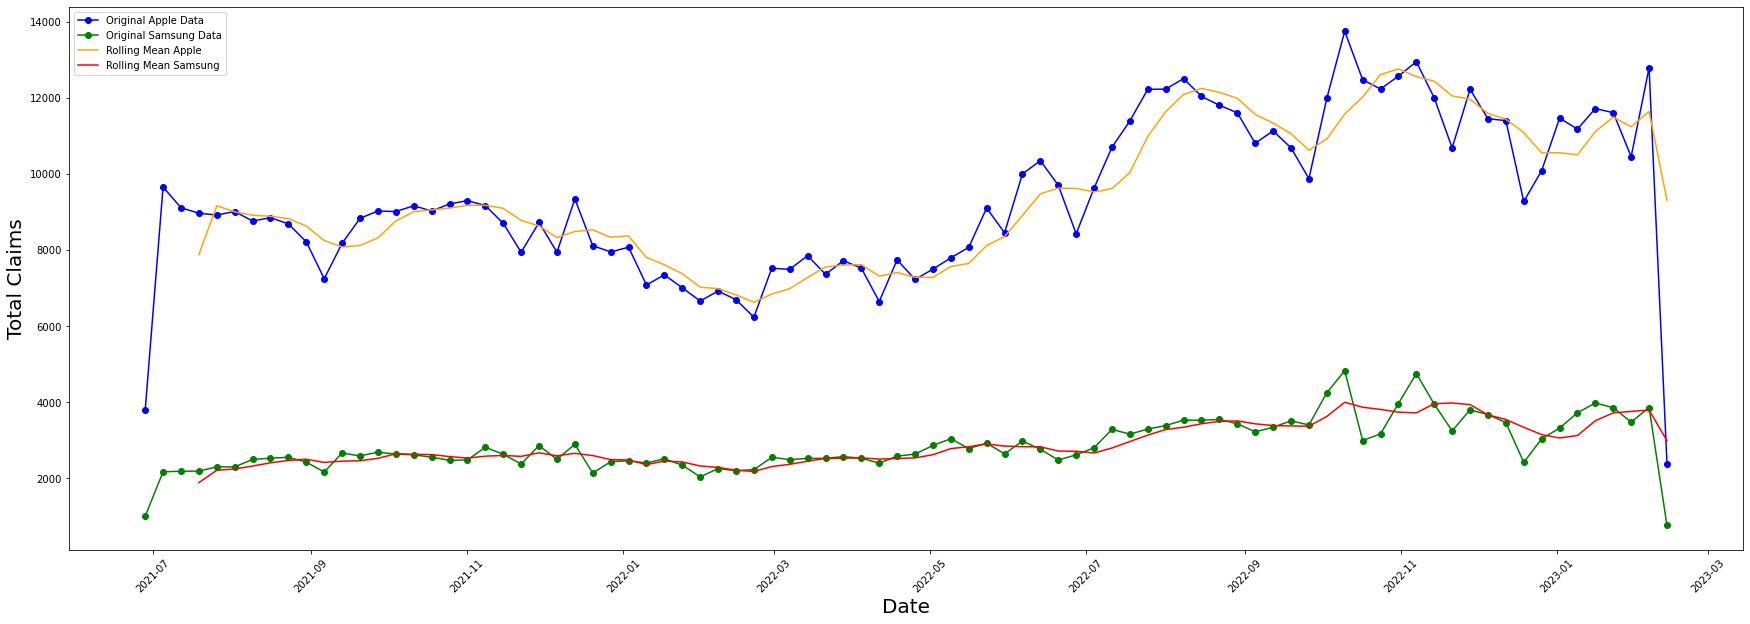

In [14]:
plt.figure(figsize=(30,10))
plt.plot(apple_new, color="blue",label="Original Apple Data", marker = "o")
plt.plot(samsung_new, color="green",label="Original Samsung Data", marker = "o")
plt.plot(apple_rm, color="orange", label="Rolling Mean Apple")
plt.plot(samsung_rm, color="red", label="Rolling Mean Samsung")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Total Claims", fontsize = 20)
plt.show()

### Comments
* It appears that the Samsung data is clearly stationary, while the apple data is not as clear. 
* It also does appear that a rise/dip in claims is consistent between the two, showing that claims in general have time related trends, regardless of phone make.

# Meeting notes key points
* We need to trim the data to only include certain makes and certain models within those makes.
* For example, I do not think we need to use iPhone data that is pre iPhone 11 (make plot to show claims)
* We also may want to use a forecasting model that assumes stationarity based on plot above.
* We need to try and clean up data and maybe focus on each phone as 1 model, aka no difference between 11 pro and 11.

* Add ons for plots - vertical lines to show when phones released and more. Will add more plots below if get to it.

### Replotting with newer data
> Will remake time series plots with the grouped apple data

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('/data/p_dsi/teams2023/team9/')

df = pd.read_csv('Asurion_clean_data_feature_set.csv')

df['weeks_monday'] = pd.to_datetime(df['weeks_monday'], format='%Y-%m-%d')

df.head()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [20]:
df_new = df.groupby(["weeks_monday", "model_group"]).agg({"claim": ["sum"]})
df_new.columns = ["claims"]

print(df_new.head())

                          claims
weeks_monday model_group        
2021-06-28   iphone 11      1499
             iphone 12       422
             iphone se        55
             iphone x       1297
2021-07-05   iphone 11      4068


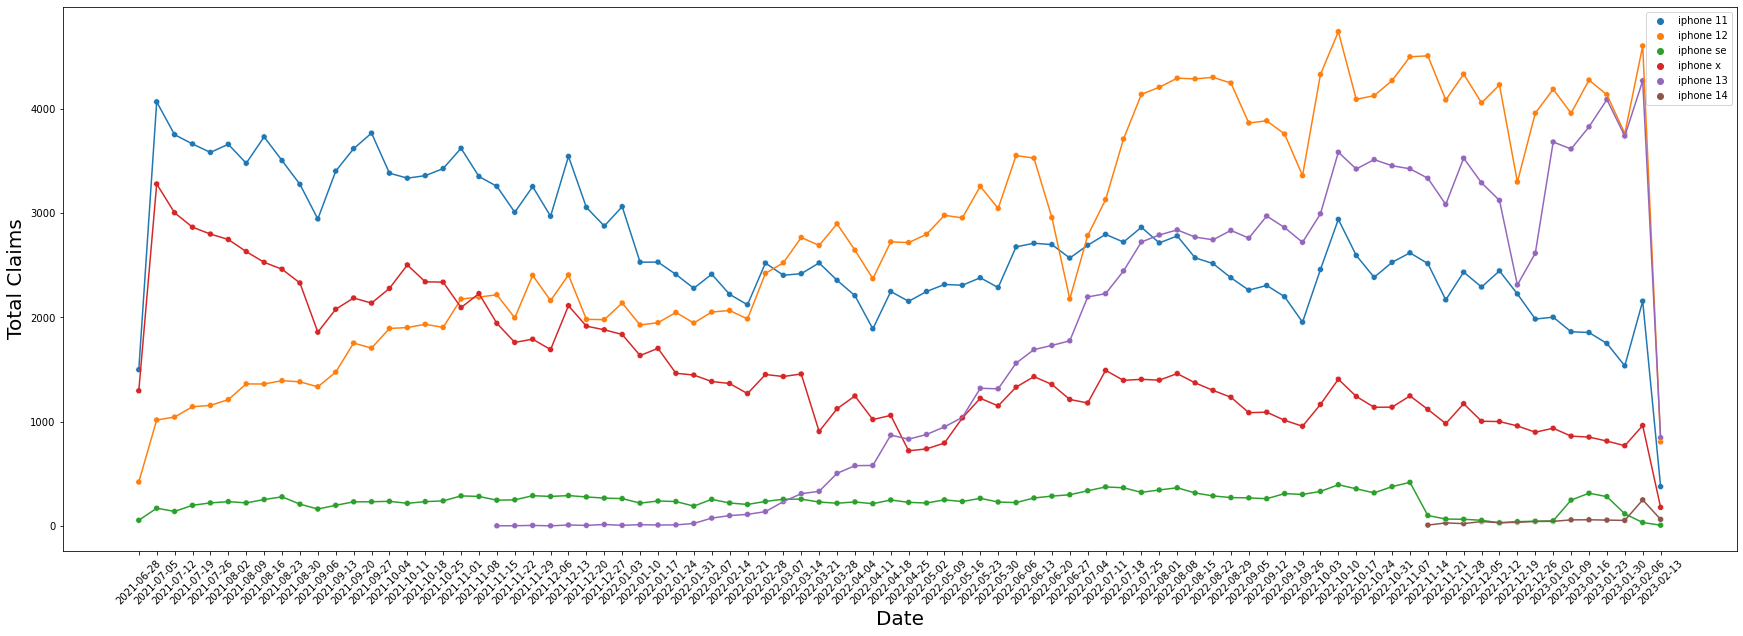

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,10))
sns.scatterplot(data=df_new, x='weeks_monday', y='claims', hue='model_group', sizes=(50,500))
sns.lineplot(data=df_new, x='weeks_monday', y='claims', hue='model_group', legend = False)
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Total Claims", fontsize = 20)
plt.show()

## Notes
- iPhone 14 has really low claims due to it releasing within the last year. Look at iPhone 13 as an example, it took a while to start ramping up.  
- May want to disregard the last dates, as they all took a drop but that severe of a drop seems like it may be an error in the data.  
- Curious about the severe drop in iPhone 12 in June 2022.  
- Older models appear to be more stationary than the newer ones, as the iPhone 12 and 13 climbed a lot rather unsteadily, whereas older models were pretty consistent in their changes.